In [31]:
import numpy as np
import pandas as pd
from pyomo.environ import ConcreteModel, RangeSet, Var, NonNegativeReals, Objective, minimize
from pyomo.environ import Expression, Constraint, Binary, SolverFactory, value, Param
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib

In [32]:
''' Multi-Objective Optimization (Epsilon-constraint method) '''

''' Read problem inputs '''

# Load the uploaded Excel file
df = pd.read_excel('inputs/data.xlsx', sheet_name='Hoja1')
df = df.iloc[:100]

# Remove any trailing spaces from column names
df.columns = df.columns.str.strip()

# Return and std of each asset
avg_returns = np.array(df['Return'])
st_devs = np.array(df['Risk'])
num_assets = len(avg_returns)

# ESG scores
des_levels = np.array(df['Desirability'])
fea_levels = np.array(df['Feasibility'])
sus_levels = np.array(df['Sustainability'])

# Calculate correlation between assets
df_returns = df[['Symbol', 'return_1', 'return_2', 'return_3', 'return_4', 'return_5', 'return_6', 'return_7', 'return_8',
                'return_9','return_10','return_11','return_12','return_13','return_14','return_15','return_16','return_17',
                'return_18','return_19','return_20','return_21','return_22','return_23','return_24','return_25','return_26',
                'return_27','return_28','return_29','return_30','return_31','return_32','return_33','return_34']]

df_returns.set_index('Symbol', inplace=True)
df_returns = df_returns.T

corr_matrix = df_returns.corr()
corr_matrix.to_csv('df_corr.csv')

# Correlation between assets
df1 = pd.read_csv('df_corr.csv', index_col=0)
corr_matrix = np.array(df1.values)

# Compute the covariance matrix
cov_matrix = np.zeros((num_assets, num_assets))
for i in range(num_assets):
    for j in range(num_assets):
        corr = corr_matrix[i][j]
        cov = st_devs[i] * st_devs[j] * corr
        cov_matrix[i][j] = cov
        cov_matrix[j][i] = cov

# Get return thresholds to build the efficient frontier
min_value = 0.07
max_value = 0.15
step = (max_value - min_value) / 49
return_thresholds = [round(min_value + step * i, 6) for i in range(50)]

with open("portef.txt", "w") as file:
    for threshold in return_thresholds:
        file.write(str(threshold) + "\n")

# Return thresholds
return_thresholds = []
with open('portef.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        values = line.split()    
        return_threshold = float(values[0])
        return_thresholds.append(return_threshold)

In [33]:
def solve_POP(returns, filename, des_value, sus_value, fea_value):

    ''' Define problem parameters '''

    n_min = 3
    n_max = 7
    min_xi = 0.0
    max_xi = 1.0
    big_M = 1e20 # very large number

    # Set to different values each time
    des_threshold = des_value
    sus_threshold = sus_value
    fea_threshold = fea_value


    ''' Generate the Pyomo-Gurobi model '''

    model = ConcreteModel() # define the Pyomo model
    model.I = RangeSet(1, num_assets) # define set of indexes
    model.x = Var(model.I, domain=NonNegativeReals) # define variables


    ''' Define the objective function '''

    def portf_risk_rule(model):
        p_risk = sum(sum(cov_matrix[i-1][j-1] * model.x[i] * model.x[j] for j in model.I) for i in model.I)
        return p_risk

    # Expressions to compute portfolio objectives
    model.portf_risk = Objective(rule=portf_risk_rule, sense=minimize)
    model.portf_return = Expression(expr=sum(returns[i-1] * model.x[i] for i in model.I))
    model.portf_des = Expression(expr=sum(des_levels[i-1] * model.x[i] for i in model.I))
    model.portf_fea = Expression(expr=sum(fea_levels[i-1] * model.x[i] for i in model.I))
    model.portf_sus = Expression(expr=sum(sus_levels[i-1] * model.x[i] for i in model.I))


    ''' Add constraints '''

    # Budget contraint
    model.sum_weights_cons = Constraint(expr = sum(model.x[i] for i in model.I) <= 1.0)

    # Return threshold constraint
    model.return_threshold = Param(initialize=0.0, mutable=True) 
    model.return_cons = Constraint(expr = model.portf_return >= model.return_threshold)

    # Positive weights constraint
    model.low_weight_cons = Constraint(model.I, rule=lambda model, i: model.x[i] >= 0)

    # Portfolio environmental level constraint
    model.des_cons = Constraint(expr = model.portf_des >= des_threshold)

    # Portfolio social level constraint
    model.fea_cons = Constraint(expr = model.portf_fea >= fea_threshold)

    # Portfolio governance level constraint
    model.sus_cons = Constraint(expr = model.portf_sus >= sus_threshold)

    # Cardinality constraints
    model.is_asset_selected = Var(model.I, within=Binary)
    for i in model.I:
        model.is_asset_selected[i] = 0  

    def is_asset_selected_rule_1(model, i):
        return model.x[i] <= model.is_asset_selected[i] * big_M
    model.is_asset_selected_cons_1 = Constraint(model.I, rule=is_asset_selected_rule_1)

    def is_asset_selected_rule_2(model, i):
        return model.is_asset_selected[i] <= model.x[i] * big_M
    model.is_asset_selected_cons_2 = Constraint(model.I, rule=is_asset_selected_rule_2)

    def count_selected_assets_rule(model):
        return sum(model.is_asset_selected[i] for i in model.I)
    model.num_selected_assets = Expression(rule=count_selected_assets_rule)

    model.portf_size_lb_cons = Constraint(expr = model.num_selected_assets >= n_min)
    model.portf_size_ub_cons = Constraint(expr = model.num_selected_assets <= n_max)

    # Minimum and maximum investment constraints
    model.up_weight_cons = Constraint(model.I, rule=lambda model, i: model.x[i] <= max_xi)

    def select_asset_min_invest_rule(model, i):
        return model.x[i] >= min_xi * model.is_asset_selected[i]
    model.select_asset_min_invest_cons = Constraint(model.I, rule=select_asset_min_invest_rule)


    ''' Choose a solver engine '''

    solver = SolverFactory('gurobi')


    ''' Solve the optimization problem for each return threshold '''

    print('Solving the POP for different return thresholds...')
    results = []
    k = 0
    for threshold in return_thresholds:
        k = k + 1
        print('Solving POP ' + str(k) + ' of ' + str(len(return_thresholds)))
        for i in model.I: # reset all is_asset_selected to 0
            model.is_asset_selected[i] = 0
        model.return_threshold = threshold # update the return threshold parameter
        solver.solve(model) # solve the optimization problem
        opt_weights = [round(value(model.x[i]), 4) for i in model.I] # extract opt sol (asset weights)
        risk = round(value(model.portf_risk()), 6) # extract minimized risk value
        exp_return = round(value(model.portf_return), 6)
        des = round(value(model.portf_des), 2)
        fea = round(value(model.portf_fea), 2)
        sus = round(value(model.portf_sus), 2)
        n_selected = value(model.num_selected_assets)
        #selected_weights = [i for i, x in enumerate(opt_weights) if x != 0]
        #n_selected = len(selected_weights)
        results.append({'Return': exp_return, 'Risk': risk, 'Des': des, 'Sus': sus, 'Fea': fea,
                        'N selected': n_selected, 'Weights': opt_weights})


    ''' Export results to a CSV file '''

    csv_file_path = filename
    with open(csv_file_path, mode='w', newline='') as file:
        fieldnames = ['Return', 'Risk', 'Des', 'Sus', 'Fea', 'N selected', 'Weights']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for result in results:
            writer.writerow(result)
    print('Results have been exported to CSV file.')

    return results

In [34]:
static_results = solve_POP(avg_returns, 'port_results.csv', 0, 0, 0)

Solving the POP for different return thresholds...
Solving POP 1 of 50
Solving POP 2 of 50
Solving POP 3 of 50
Solving POP 4 of 50
Solving POP 5 of 50
Solving POP 6 of 50
Solving POP 7 of 50
Solving POP 8 of 50
Solving POP 9 of 50
Solving POP 10 of 50
Solving POP 11 of 50
Solving POP 12 of 50
Solving POP 13 of 50
Solving POP 14 of 50
Solving POP 15 of 50
Solving POP 16 of 50
Solving POP 17 of 50
Solving POP 18 of 50
Solving POP 19 of 50
Solving POP 20 of 50
Solving POP 21 of 50
Solving POP 22 of 50
Solving POP 23 of 50
Solving POP 24 of 50
Solving POP 25 of 50
Solving POP 26 of 50
Solving POP 27 of 50
Solving POP 28 of 50
Solving POP 29 of 50
Solving POP 30 of 50
Solving POP 31 of 50
Solving POP 32 of 50
Solving POP 33 of 50
Solving POP 34 of 50
Solving POP 35 of 50
Solving POP 36 of 50
Solving POP 37 of 50
Solving POP 38 of 50
Solving POP 39 of 50
Solving POP 40 of 50
Solving POP 41 of 50
Solving POP 42 of 50
Solving POP 43 of 50
Solving POP 44 of 50
Solving POP 45 of 50
Solving POP 4

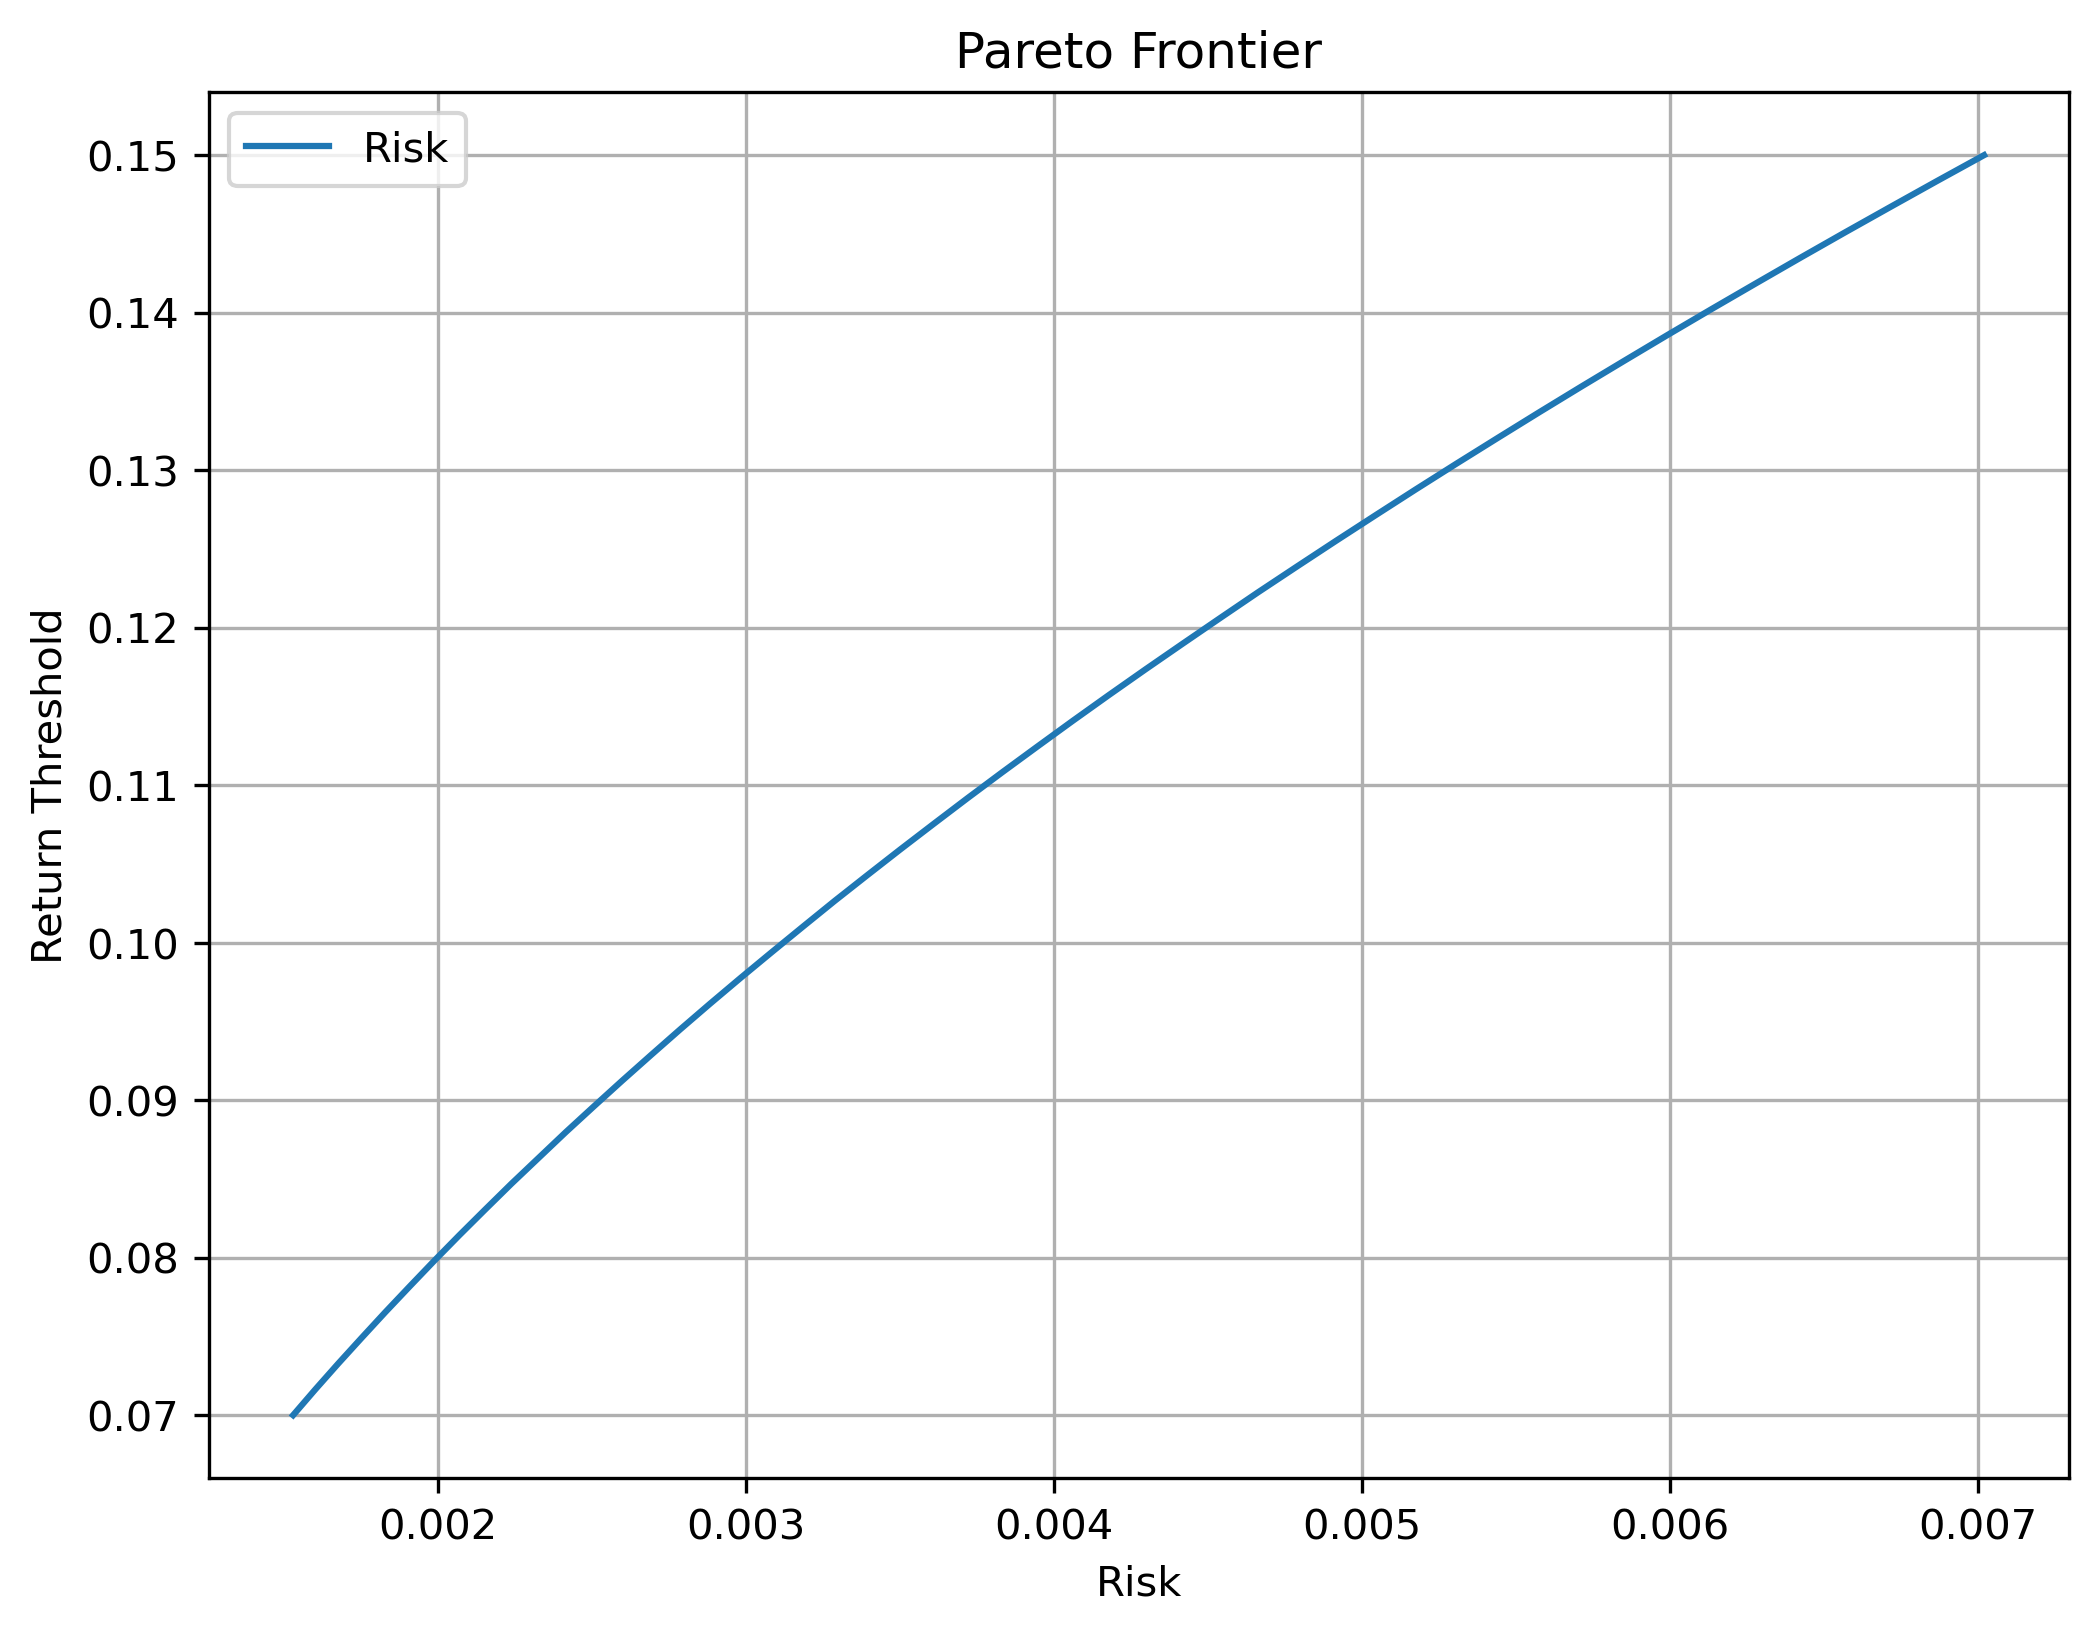

In [35]:
''' Frontiers figure (Static) '''

# Load data from the excel file
df2 = pd.read_csv('port_results.csv')

# First column contains the 'Return threshold' and the other contains the 'Risk'
return_threshold = df2.iloc[:, 0]
risk_column = df2.iloc[:, 1]

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(risk_column, return_threshold, label = "Risk")
plt.xlabel('Risk')
plt.ylabel('Return Threshold')
plt.title('Pareto Frontier')
plt.legend()
plt.grid(True)
plt.savefig('pareto_frontier.png', dpi=300)
plt.show()

In [36]:
dsf1_results = solve_POP(avg_returns, 'port_results_dsf1.csv', 0.5, 0.3, 0.2)
dsf2_results = solve_POP(avg_returns, 'port_results_dsf2.csv', 0.65, 0.4, 0.25)
dsf3_results = solve_POP(avg_returns, 'port_results_dsf3.csv', 0.75, 0.55, 0.3)

Solving the POP for different return thresholds...
Solving POP 1 of 50
Solving POP 2 of 50
Solving POP 3 of 50
Solving POP 4 of 50
Solving POP 5 of 50
Solving POP 6 of 50
Solving POP 7 of 50
Solving POP 8 of 50
Solving POP 9 of 50
Solving POP 10 of 50
Solving POP 11 of 50
Solving POP 12 of 50
Solving POP 13 of 50
Solving POP 14 of 50
Solving POP 15 of 50
Solving POP 16 of 50
Solving POP 17 of 50
Solving POP 18 of 50
Solving POP 19 of 50
Solving POP 20 of 50
Solving POP 21 of 50
Solving POP 22 of 50
Solving POP 23 of 50
Solving POP 24 of 50
Solving POP 25 of 50
Solving POP 26 of 50
Solving POP 27 of 50
Solving POP 28 of 50
Solving POP 29 of 50
Solving POP 30 of 50
Solving POP 31 of 50
Solving POP 32 of 50
Solving POP 33 of 50
Solving POP 34 of 50
Solving POP 35 of 50
Solving POP 36 of 50
Solving POP 37 of 50
Solving POP 38 of 50
Solving POP 39 of 50
Solving POP 40 of 50
Solving POP 41 of 50
Solving POP 42 of 50
Solving POP 43 of 50
Solving POP 44 of 50
Solving POP 45 of 50
Solving POP 4

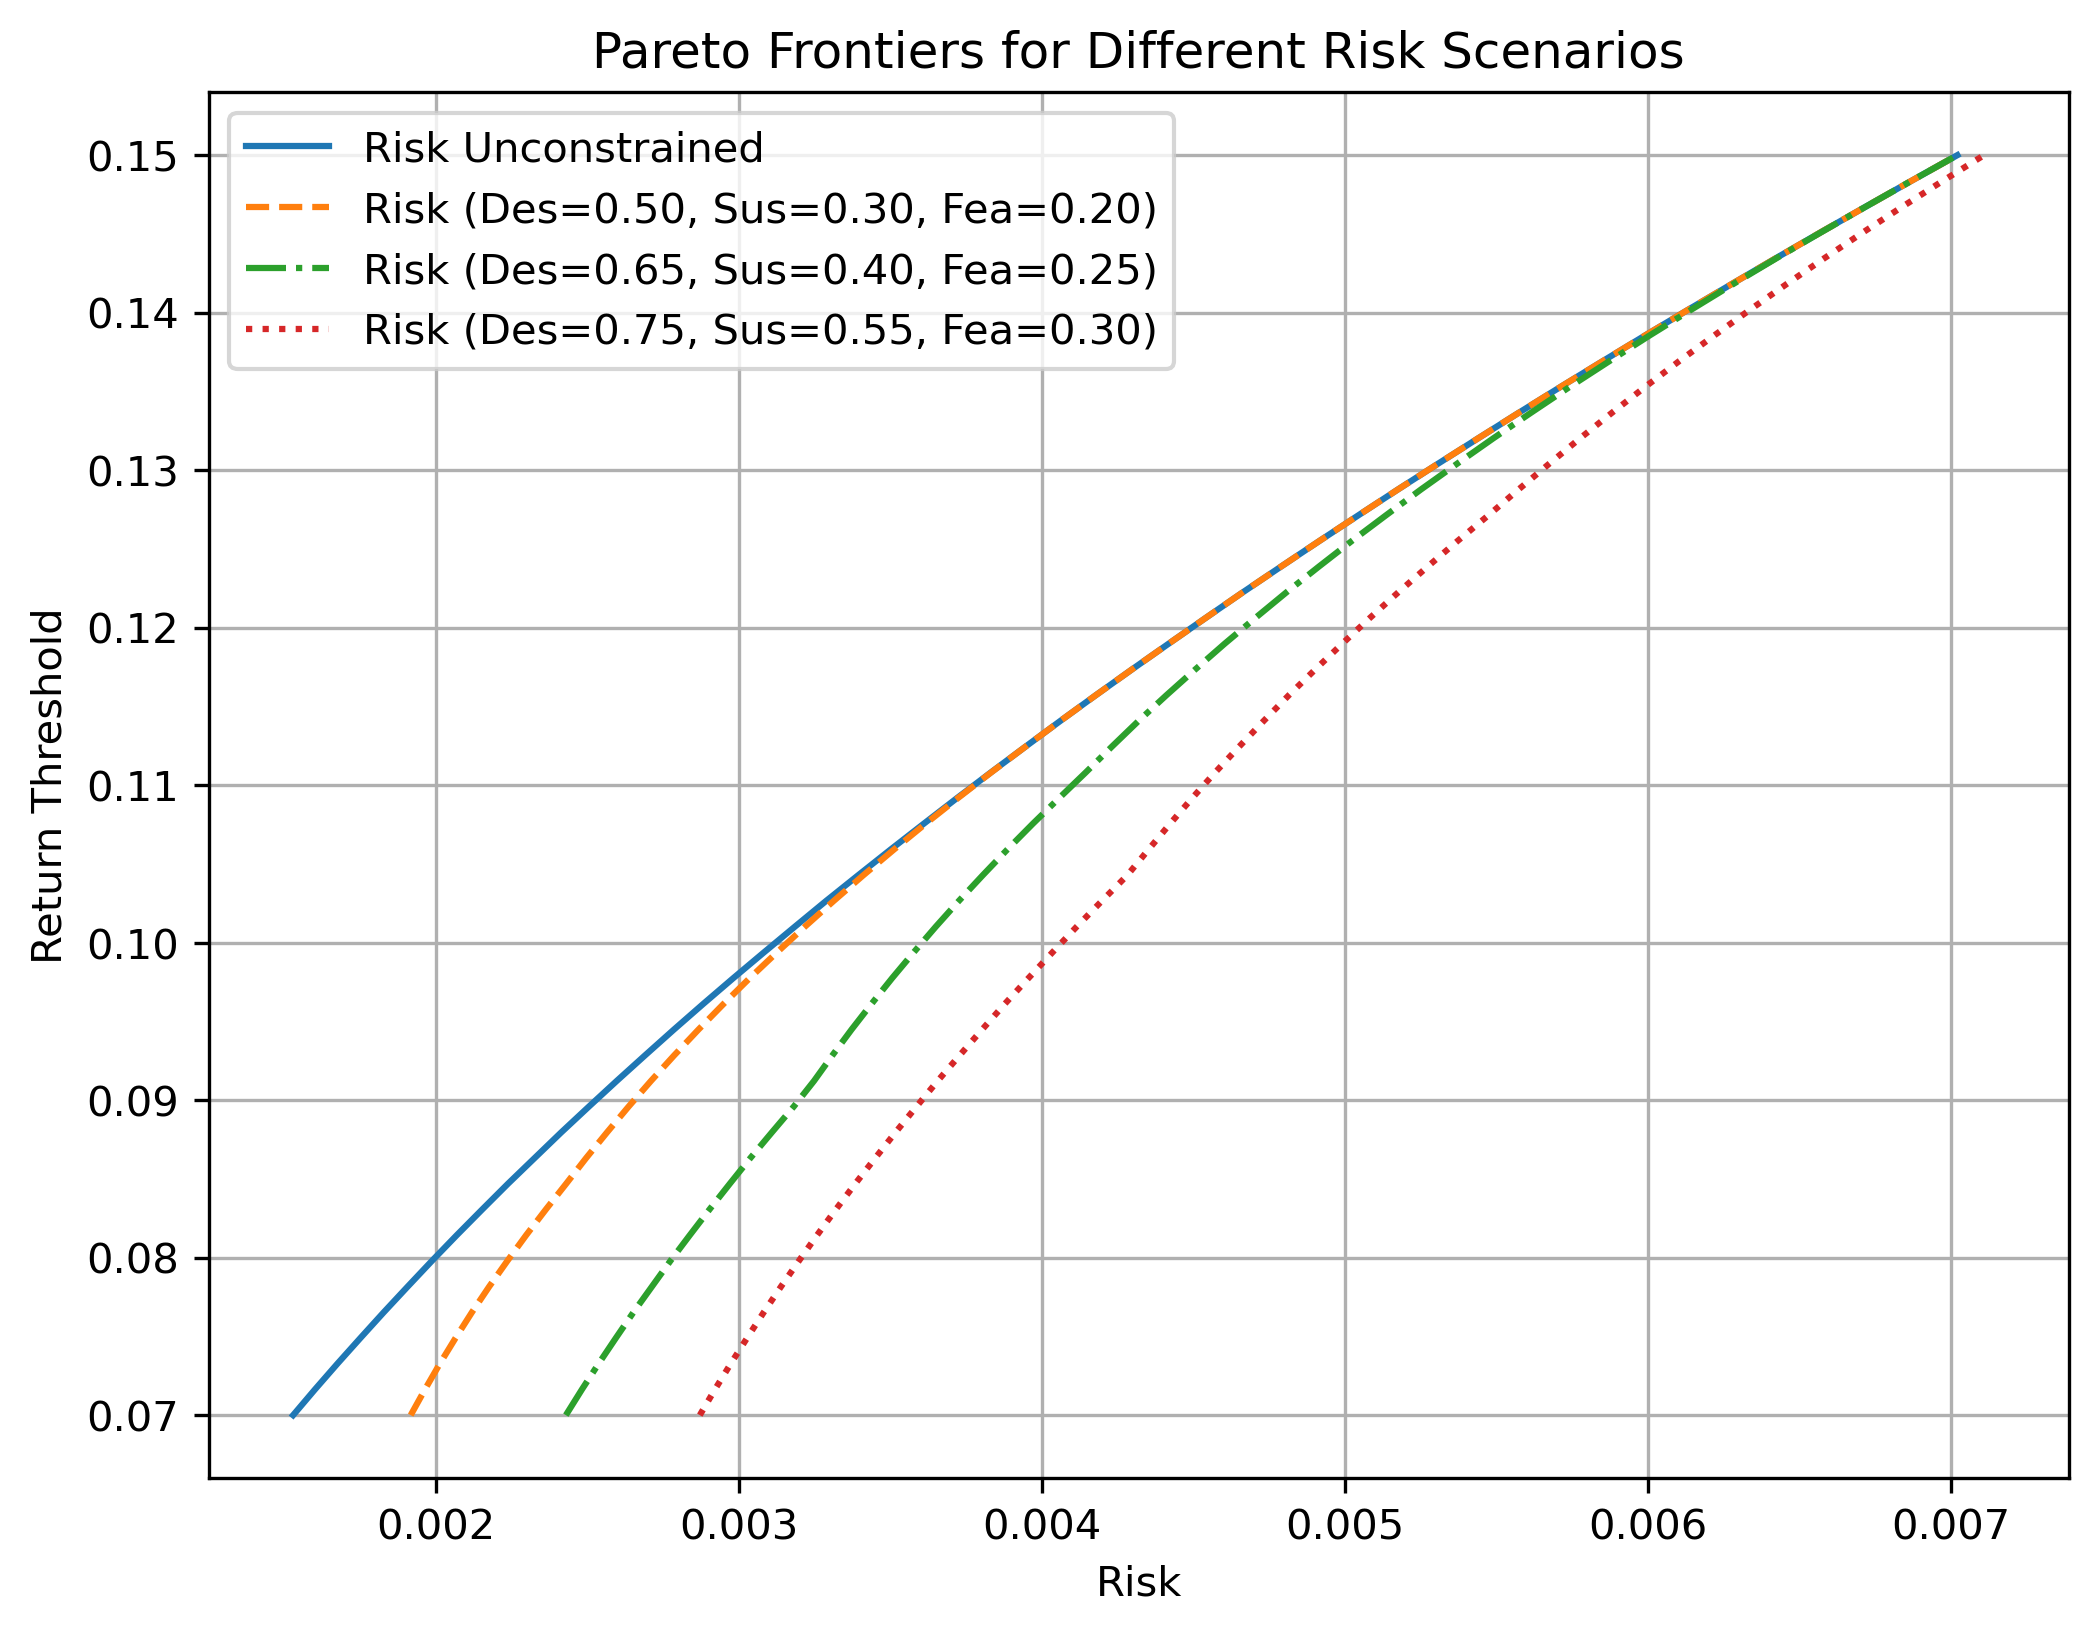

In [42]:
''' Frontiers figure (DFS values) '''

# Load data from the excel file
df3 = pd.read_excel('return vs risk (DFS).xlsx')

return_threshold = df3.iloc[:, 0]
risk_columns = df3.iloc[:, 1:]

line_styles = ['-', '--', '-.', ':']
plt.figure(figsize=(8, 6), dpi=300)
# Pareto frontiers for 'Risk' scenarios against the shared 'Return threshold'
for i, col in enumerate(risk_columns.columns):
    plt.plot(risk_columns[col], return_threshold, label=f"{col}", linestyle=line_styles[i % len(line_styles)])

plt.xlabel('Risk')
plt.ylabel('Return Threshold')
plt.title('Pareto Frontiers for Different Risk Scenarios')
plt.legend()
plt.grid(True)
plt.savefig('pareto_frontiers_DSF.png', dpi=300)
plt.show()

In [38]:
''' Synergies -  Calculate estimated average returns with synergy model and execute Pyomo-Gurobi '''

# Load trained synergy model
synergy_model = joblib.load('XGB_model.sav')

# Create new variables
synergy_returns = avg_returns.copy()
synergies_list = []

# Recalculate returns array using synergies
for i in range(num_assets):
    # List to store synergies of assets
    asset_synergies = []
    # Total synergy of each asset with the rest of the portfolio
    total_synergy = 0

    for j in range(num_assets):    
        if i != j:
            # Prepare input data for the model
            data = {
                'Asset_A_Desirability': df.loc[i, 'Desirability'],
                'Asset_A_Sustainability': df.loc[i, 'Sustainability'],
                'Asset_A_Feasibility': df.loc[i, 'Feasibility'],
                'Asset_B_Desirability': df.loc[j, 'Desirability'],
                'Asset_B_Sustainability': df.loc[j, 'Sustainability'],
                'Asset_B_Feasibility': df.loc[j, 'Feasibility']
            }
            
            data_input = pd.DataFrame([data])

            # Predict synergy between asset i and j using the model
            synergy = synergy_model.predict(data_input)[0]
            total_synergy += synergy

            # Save synergies
            asset_synergies.append(synergy)

    # Adjust returns and save synergies of each asset
    mean_synergy = total_synergy / (num_assets - 1)
    synergy_returns[i] = mean_synergy * avg_returns[i]
    synergies_list.append({i: asset_synergies})

synergy_results = solve_POP(synergy_returns, 'port_results_synergy.csv', 0, 0, 0)

Solving the POP for different return thresholds...
Solving POP 1 of 50
Solving POP 2 of 50
Solving POP 3 of 50
Solving POP 4 of 50
Solving POP 5 of 50
Solving POP 6 of 50
Solving POP 7 of 50
Solving POP 8 of 50
Solving POP 9 of 50
Solving POP 10 of 50
Solving POP 11 of 50
Solving POP 12 of 50
Solving POP 13 of 50
Solving POP 14 of 50
Solving POP 15 of 50
Solving POP 16 of 50
Solving POP 17 of 50
Solving POP 18 of 50
Solving POP 19 of 50
Solving POP 20 of 50
Solving POP 21 of 50
Solving POP 22 of 50
Solving POP 23 of 50
Solving POP 24 of 50
Solving POP 25 of 50
Solving POP 26 of 50
Solving POP 27 of 50
Solving POP 28 of 50
Solving POP 29 of 50
Solving POP 30 of 50
Solving POP 31 of 50
Solving POP 32 of 50
Solving POP 33 of 50
Solving POP 34 of 50
Solving POP 35 of 50
Solving POP 36 of 50
Solving POP 37 of 50
Solving POP 38 of 50
Solving POP 39 of 50
Solving POP 40 of 50
Solving POP 41 of 50
Solving POP 42 of 50
Solving POP 43 of 50
Solving POP 44 of 50
Solving POP 45 of 50
Solving POP 4

In [39]:
''' Calculate real average returns with black box (rules) '''

# Save mean values
mean_des = round(df['Desirability'].mean(), 2)
mean_sus = round(df['Sustainability'].mean(), 2)
mean_fea = round(df['Feasibility'].mean(), 2)

# Adjust synergy based on the rules
def synergy_rules_dsf(asset_A, asset_B, mean_value, synergy):
    if asset_A > mean_value and asset_B > mean_value:
        synergy += 0.4
    elif asset_A < mean_value and asset_B < mean_value:
        synergy -= 0.4
    elif asset_A > mean_value and asset_B < mean_value:
        synergy += 0.3
    elif asset_A < mean_value and asset_B > mean_value:
        synergy -= 0.3

    # Special cases
    elif asset_A == mean_value and asset_B > mean_value:
        synergy += 0.2
    elif asset_A == mean_value and asset_B < mean_value:
        synergy -= 0.2
    elif asset_A > mean_value and asset_B == mean_value:
        synergy += 0.2
    elif asset_A < mean_value and asset_B == mean_value:
        synergy -= 0.2
    elif asset_A == mean_value and asset_B == mean_value:
        if asset_A > 0.5:
            synergy += 0.2
        else:
            synergy -= 0.2
    
    return synergy

# Calculate the synergy between two assets
def calculate_synergy(asset1, asset2, df):
    synergy = 1
    
    # Get features from assets 1 and 2
    asset1_info = df.loc[asset1]
    asset2_info = df.loc[asset2]

    # Calculate synergy between asset1 and asset2
    synergy = synergy_rules_dsf(asset1_info['Desirability'], asset2_info['Desirability'], mean_des, synergy)
    synergy = synergy_rules_dsf(asset1_info['Sustainability'], asset2_info['Sustainability'], mean_sus, synergy)
    synergy = synergy_rules_dsf(asset1_info['Feasibility'], asset2_info['Feasibility'], mean_fea, synergy)

    return synergy

# Create new variable
real_returns = avg_returns.copy()

for i in range(num_assets):
    total_synergy = 0
    for j in range(num_assets):
        if i != j:
            synergy = calculate_synergy(i, j, df)
            total_synergy += synergy

    mean_synergy = total_synergy / (num_assets - 1)
    real_returns[i] = mean_synergy * avg_returns[i]

In [40]:
''' Comparison - Curves to real-world scenario'''

# Initialize an empty list
adjusted_returns_static = []
adjusted_returns_synergy = []

# Iterate over each portfolio in the static curve
for result in static_results:
    # Get the indices and weights of selected assets
    selected_assets = [index for index, weight in enumerate(result['Weights']) if weight != 0.0]
    selected_weights = [weight for weight in result['Weights'] if weight != 0.0]

    # Calculate the adjusted return
    adjusted_return = sum(real_returns[i] * selected_weights[selected_assets.index(i)] for i in selected_assets)
    
    # Save the adjusted return to the list
    adjusted_returns_static.append(adjusted_return)

# Export the adjusted returns to a CSV file
df_adjusted_returns = pd.DataFrame({'Adjusted_Returns_Static': adjusted_returns_static})
df_adjusted_returns.to_csv('adjusted_returns_static.csv', index=False)

# Iterate over each portfolio in the synergy curve
for result in synergy_results:
    # Get the indices and weights of selected assets
    selected_assets = [index for index, weight in enumerate(result['Weights']) if weight != 0.0]
    selected_weights = [weight for weight in result['Weights'] if weight != 0.0]

    # Calculate the adjusted return
    adjusted_return = sum(real_returns[i] * selected_weights[selected_assets.index(i)] for i in selected_assets)
    
    # Save the adjusted return to the list
    adjusted_returns_synergy.append(adjusted_return)

# Export the adjusted returns to a CSV file
df_adjusted_returns = pd.DataFrame({'Adjusted_Returns_Synergy': adjusted_returns_synergy})
df_adjusted_returns.to_csv('adjusted_returns_synergy.csv', index=False)
print('Adjusted returns have been exported to CSV files.')

Adjusted returns have been exported to CSV files.


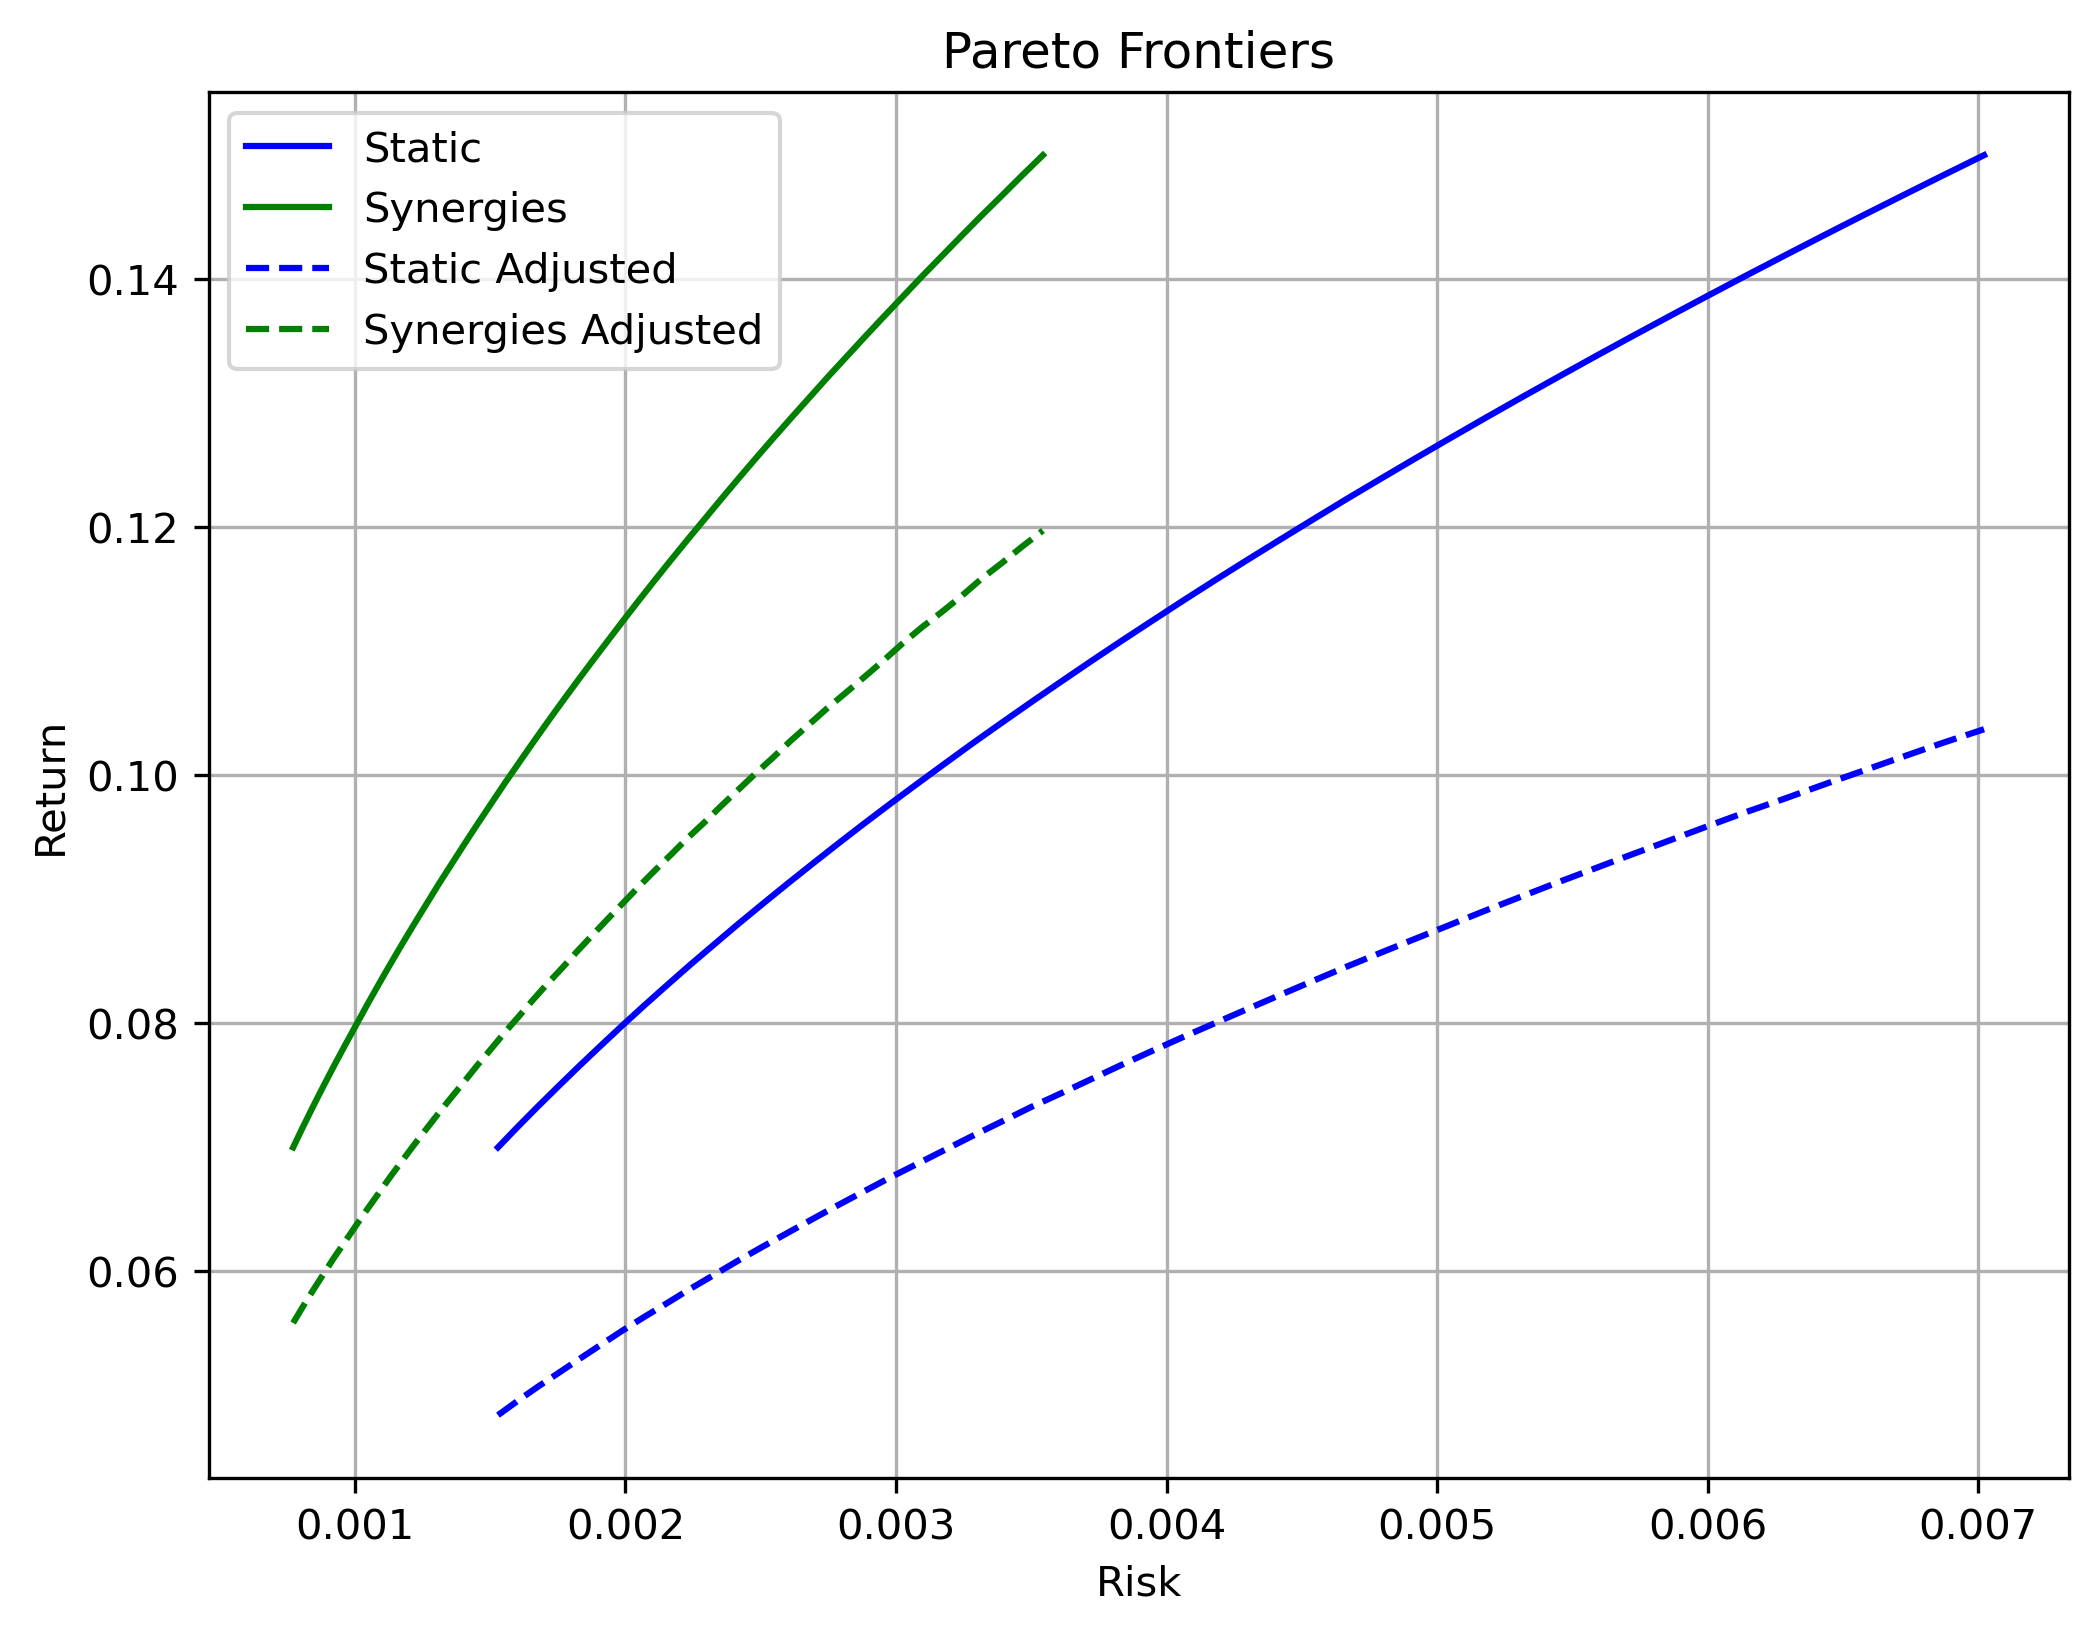

In [41]:
''' Frontiers figure (Comparison) '''

# Load data from the excel file
df4 = pd.read_excel('return vs risk (comparison).xlsx')

# Extract data
# First curve
return_static = df4['Return (static)']
risk_static = df4['Risk (static)']
# Second curve
risk_synergies = df4['Risk (synergies)']
# Third curve
return_static_adjusted = df4['Return (static adjusted)']
#Fourth curve
return_synergies_adjusted = df4['Return (synergies adjusted)']


plt.figure(figsize=(8, 6), dpi=300)

plt.plot(risk_static, return_static, label="Static", linestyle='-', color='blue')
plt.plot(risk_synergies, return_static, label="Synergies", linestyle='-', color='green')
plt.plot(risk_static, return_static_adjusted, label="Static Adjusted", linestyle='--', color='blue')
plt.plot(risk_synergies, return_synergies_adjusted, label="Synergies Adjusted", linestyle='--', color='green')

plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Pareto Frontiers')
plt.legend()
plt.grid(True)
plt.savefig('pareto_frontiers_comparison.png', dpi=300)
plt.show()